In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import scipy.sparse.csgraph
import sklearn.neighbors
from scipy.sparse import csr_matrix
import networkx as nx

import sys
# setting path
sys.path.append('../../')
import modules.find_patches_community_detection as find_patches

In [14]:
# set defaults for pytorch
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.manual_seed(42)

In [2]:
# download dataset
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
dataset = datasets.MNIST(root='./torch-dataset', train=True,
                         download=True, transform=transform)

In [3]:
# load dataset into pytorch
data_loader = torch.utils.data.DataLoader(dataset, batch_size=600000)
data,labels = next(iter(data_loader))
data = data.cuda()

torch.Size([5958, 1, 32, 32])


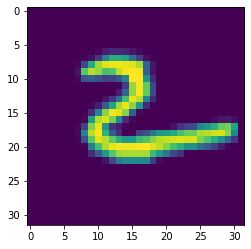

In [4]:
# select single class of dataset
Z = data[labels==2]
print(Z.shape)
# reshape array to (d x n) data matrix
Z = Z.reshape((5958,32**2))
Z = Z.T

d, n = Z.shape
# demonstrate data structure was preserved in reshape
plt.imshow(Z[:,6].detach().cpu().numpy().reshape(32,32))

In [6]:
Z_cpu = Z.cpu()

In [7]:
# test neighborhood computation
ind = find_patches.find_patches(Z_cpu)

finished building graph


In [9]:
print(len(ind))

4


# Geodesic analysis

We first analyze the EDM structure to determine how to discretize manifold

In [6]:
# get gram matrix of data
gram = Z.T @ Z
# gram matrix, but set all non-diagonal entries to 0
gram_diag = torch.diag(torch.diag(gram))
# get squared euclidean distances of data
edm = gram_diag @ torch.ones((n,n)) + torch.ones((n,n)) @ gram_diag \
		- 2*gram

(array([3.400e+02, 2.095e+03, 2.151e+03, 9.340e+02, 3.170e+02, 9.100e+01,
        2.200e+01, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([ 70.135376, 105.45935 , 140.78333 , 176.1073  , 211.43127 ,
        246.75525 , 282.07922 , 317.4032  , 352.72717 , 388.05115 ,
        423.37512 ], dtype=float32),
 <BarContainer object of 10 artists>)

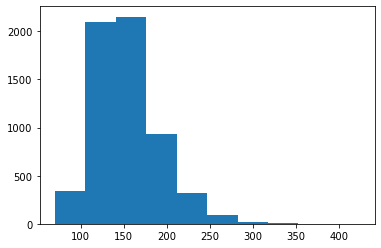

In [7]:
# sorted so each row is in strictly increasing order
edm_sort = edm.sort(axis=1)
# print histogram of k^{th} lowest distance for each point
k = 12
# get kth largest distance from each object
edm_kthlargest = edm_sort.values[:,k]
plt.hist(edm_kthlargest.cpu().detach().numpy())

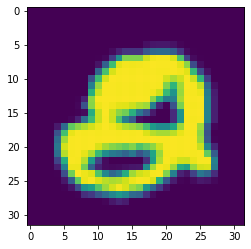

In [8]:
# print datapoints with maximal minimum distance
max_kdist_arg = torch.argmax(edm_sort.values[:,k])
ind_i = max_kdist_arg
ind_j = edm_sort.indices[max_kdist_arg, k]
plt.imshow(Z[:,ind_i].detach().cpu().numpy().reshape(32,32))


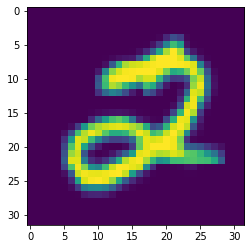

In [9]:
plt.imshow(Z[:,ind_j].detach().cpu().numpy().reshape(32,32))

Create $k$-NN graph to search for geodesics between arbitrary data points

In [28]:
k = 12
source = 0
print('building knn graph...')
knn_graph = sklearn.neighbors.kneighbors_graph(Z.cpu().detach().numpy().T, k, mode='distance')
print('computing min-dist search from source')
# compute approximate geodesic distances (g_dist) and predecessors for geodesic
# (g_predecessor) from Z[:,source]
g_dist, g_predecessor = scipy.sparse.csgraph.shortest_path(knn_graph, directed=False, indices=source, return_predecessors=True)
print('done!')


building knn graph...
computing min-dist search from source
done!


In [33]:
# build geodesic from source to dest
dest = 2
g_list = Z[:,[dest]].clone()
# track where we currently are in the geodesic
curr_pos = dest
while curr_pos != source:
	curr_pos = g_predecessor[curr_pos]
	g_list = torch.hstack((Z[:,[curr_pos]], g_list))

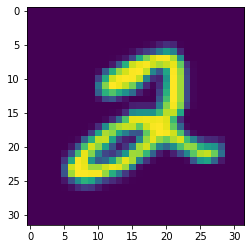

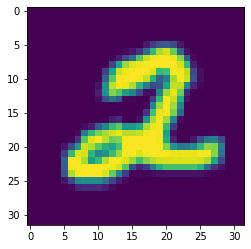

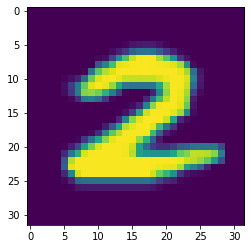

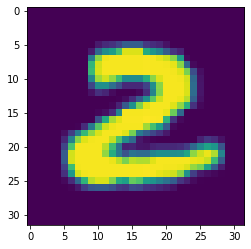

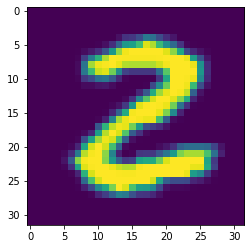

In [34]:
for i in range(g_list.shape[1]):
	plt.imshow(g_list[:,i].detach().cpu().numpy().reshape(32,32))
	plt.show()
	

# testing full linearization

In [8]:
# PyTorch model to optimize our custom loss
class CurvatureElimination(nn.Module):

	def __init__(self, X, u_0):
		super(CurvatureElimination, self).__init__();
		# data
		self.X = X
		# construct edm and gamma weight matrix
		gram = X.T@X
		edm = torch.diag(gram).reshape((n,1))@torch.ones((1,n)) \
				+ torch.ones((n,1))@torch.diag(gram).reshape((1,n)) \
				- 2*gram

		# diagonal weights don't matter, set to 1 as convention
		self.gamma = torch.divide(torch.Tensor([1]),torch.eye(n) + edm)
		# projection vec
		self.u = nn.Parameter(u_0)

	def forward(self):
		U_stacked = torch.ones(self.X.shape)*self.u
		A = (self.X.T @ U_stacked - U_stacked.T @ self.X)*self.gamma
		return 0.5*A.pow(4).sum()

In [35]:
# optimize via projected gradient descent

u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())

U, S, V = torch.svd(Z - Z.mean(axis=1, keepdim=True))

# truncate machine-precision principal components
S_r = torch.diag(S)
r = S_r.shape[0]
U_r = U[:,:r]
V_r = V[:,:r]
Z_r = U_r @ S_r @ V_r.T

X = Z.clone()

cc = CurvatureElimination(X, u_0)
opt = optim.SGD(cc.parameters(), lr=100)

for i in range(100):
	cc.zero_grad()
	# forward call of LinFlow
	loss = cc()

	loss.backward()

	# compute Riemannian gradient
	egrad = cc.u.grad.detach()
	base = cc.u.data.detach()
	base = base / torch.sqrt(base.pow(2).sum())
	rgrad = egrad - base@base.t()@egrad
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		cc.u.data = cc.u.data / torch.sqrt((cc.u.data).pow(2).sum());

	# determine if we have converged
	gradnorm = torch.linalg.norm(rgrad)
	if gradnorm < 5e-5:
		# print(f'converged in {i} steps!')
		# break
		pass
	if i%10 == 0:
		print(f'g step {i}: {gradnorm}')

print('done!')

dist: 3.248880275918964e-08
g step 0: 0.008192386478185654
g step 10: 0.4594199061393738
g step 20: 0.032339584082365036


KeyboardInterrupt: 